In [1]:
from platform import python_version

print(python_version())

3.8.8


In [2]:
# Import tweepy for now. We will import the rest of the libraries as we need them.
import tweepy 

# To stream live tweets, twitter API only needs the bearer token from your twitter developer account.
bearer_token = 'AAAAAAAAAAAAAAAAAAAAAG47fgEAAAAANS3BQNSU4ryQv9wC7CUYi1kZs6Q%3D8wBK0oVfZaTKzdBmxMR3ligVUl1xa9JrU8y1IqG3PWWJyC7MVP'

# We will create an empty list here to store all the incoming tweets.
incoming_tweets = []

# Subclass of StreamingClient that will use the functions written above to clean and classify sentiment of tweets before storing them in a csv.
class MyStreamer(tweepy.StreamingClient):        
    def on_tweet(self, tweet):
        incoming_tweets.append([tweet.id, tweet.text]) #only have tweet id and text in this tweet object
        if len(incoming_tweets) == 5000: #can set any number
            streamer.disconnect() #streamer will disconnect when the count of tweets you have set in the last line is reached
            
streamer = MyStreamer(bearer_token)
streamer.add_rules(tweepy.StreamRule("World Cup lang:en -is:retweet")) #can add a specific topic here

streamer.filter()

Stream connection closed by Twitter


In [3]:
# You can use these two methods to get all the streamer rules and delete them as per your convenience.
#streamer.get_rules()
#streamer.delete_rules() # -> enter the id of the rule you get when you execute streamer.get_rules()

In [3]:
# Check the list that contains all the incoming tweets

incoming_tweets

[[1598284697469177859,
  '@BlaqBonez Sell ham for me for 40k make mesef go do Wetin u do lekki gals'],
 [1598284696303337472,
  'RT @AntBreach: Zelensky is doing planning reform. Yimbys are in control. https://t.co/UKfh4TGbMt'],
 [1598284698790367235,
  '@KyivIndependent this will not be a fortress but a graveyard'],
 [1598284695976153089,
  'RT @LvivJournal: Ukrainian men &amp; women are holding the line around Bakhmut. Enduring intensive artillery barrage/air strikes/missiles, dail…'],
 [1598284698454609920,
  "RT @OlenaHalushka: A referendum on the Act of Declaration of Ukraine's Independence was held on Dec 1, 1991. The turnout was 84%, w more th…"],
 [1598284695925850113,
  'RT @DietmarPichler1: Unfortunately still necessary:\n\n- Russia attacked Ukraine, not vice versa☑️\n- Russian narratives are based on lies☑️\n-…'],
 [1598284694411673602,
  "They're growing on our watch 😢 https://t.co/p6jNmVHev1"],
 [1598284700992217090,
  '@MOEWHU @WestHam Every team had to have 2 weeks off t

In [4]:
# Necessary Imports
from pyspark.sql import SparkSession, SQLContext

# Build a spark session - driver's memory increased for training models later.
spark = SparkSession.builder.config("spark.driver.memory", "15g").appName('Tweets').getOrCreate()

# As we have only two columns -> id and text -> we will create a list called columns containing both.
columns = ['id', 'text']

# To create a spark dataframe, we will use the following method and pass incoming_tweets and columns lists as arguments.
df = spark.createDataFrame(incoming_tweets, columns)
df.show(10)

+-------------------+--------------------+
|                 id|                text|
+-------------------+--------------------+
|1598284697469177859|@BlaqBonez Sell h...|
|1598284696303337472|RT @AntBreach: Ze...|
|1598284698790367235|@KyivIndependent ...|
|1598284695976153089|RT @LvivJournal: ...|
|1598284698454609920|RT @OlenaHalushka...|
|1598284695925850113|RT @DietmarPichle...|
|1598284694411673602|They're growing o...|
|1598284700992217090|@MOEWHU @WestHam ...|
|1598284698463375363|RT @ShuForCongres...|
|1598284702687059970|@StakeWithPride @...|
+-------------------+--------------------+
only showing top 10 rows



In [5]:
!pip install nltk

In [6]:
import nltk
#nltk.download('vader_lexicon') # one time only
from nltk.sentiment.vader import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer() # or whatever you want to call it

In [7]:
# Function to clean tweet text by removing links, special characters, punctuations using simple regex statements.
import re
def clean_tweet(tweet):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(RT)", " ", tweet).split())
    
# Function to classify the sentiment of a passed tweet using nltk sentiment method.
def get_tweet_sentiment(tweet):
    analysis = vader.polarity_scores(tweet)
    if analysis['compound'] > 0:
        return 'positive'
    elif analysis['compound'] == 0:
        return 'neutral'
    else:
        return 'negative'

In [8]:
spark.udf.register("clean_tweet", clean_tweet)
spark.udf.register("get_tweet_sentiment", get_tweet_sentiment)

<function __main__.get_tweet_sentiment(tweet)>

In [9]:
# Importing udf -> user defined functions & StringType
import re

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Initializing user defined functions
clean_tweet_udf = udf(lambda x: clean_tweet(x), StringType())
get_tweet_sentiment_udf = udf(lambda x: get_tweet_sentiment(x), StringType())

# Selecting the columns we need and applying our functions from above and storing the results in a separate column

# Note: you can use .alias() to rename the output column
df = df.select("id", "text", clean_tweet_udf("text").alias("cleaned_text"))
df = df.select("id", "cleaned_text", get_tweet_sentiment_udf("cleaned_text").alias("sentiment"))

In [10]:
df.show()

+-------------------+--------------------+---------+
|                 id|        cleaned_text|sentiment|
+-------------------+--------------------+---------+
|1598284697469177859|Sell ham for me f...|  neutral|
|1598284696303337472|Zelensky is doing...|  neutral|
|1598284698790367235|this will not be ...| negative|
|1598284695976153089|Ukrainian men amp...| negative|
|1598284698454609920|A referendum on t...|  neutral|
|1598284695925850113|Unfortunately sti...| negative|
|1598284694411673602|They re growing o...| positive|
|1598284700992217090|Every team had to...| positive|
|1598284698463375363|Zelensky is a gre...| positive|
|1598284702687059970|CF Charles When p...|  neutral|
|1598284699545513984|QLC BIG NEWS COMI...|  neutral|
|1598284697725014017|KasiPeople Steenh...| negative|
|1598284699142602753|Olly we know why ...| positive|
|1598284702821257216|Because Putin and...| positive|
|1598284702724816897|                Nope|  neutral|
|1598284702561218563|SHOPEE 11 11 BigS...|  ne

In [11]:
#df.write.format("csv").save("tweetsss")

df.toPandas().to_csv("worldCup.csv", header=True, index=False)

In [12]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [13]:
# Necessary Imports

from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SparkSession, SQLContext
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Build a spark session - driver's memory increased for training models later. 
spark = SparkSession.builder.config("spark.driver.memory", "15g").appName('TweetsTable').getOrCreate()

In [14]:
# Read first by Pandas
df = pd.read_csv("worldCup.csv")

In [15]:
df

,id,cleaned_text,sentiment
0,1598284697469177859,Sell ham for me for 40k make mesef go do Wetin...,neutral
1,1598284696303337472,Zelensky is doing planning reform Yimbys are i...,neutral
2,1598284698790367235,this will not be a fortress but a graveyard,negative
3,1598284695976153089,Ukrainian men amp women are holding the line a...,negative
4,1598284698454609920,A referendum on the Act of Declaration of Ukra...,neutral
...,...,...,...
4995,1598286359168708610,Bakhmut The Islamic Republic of Iran China and...,neutral
4996,1598286364419596289,Raytheon Awarded 1 2 Billion Contract To Deliv...,positive
4997,1598286366840066048,Dear Taiwan Take a look at Ukraine Iraq Libya ...,positive
4998,1598286365074022400,Bitget Takes on World Cup 2022 with Messi to I...,positive


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            5000 non-null   int64 
 1   cleaned_text  4997 non-null   object
 2   sentiment     5000 non-null   object
dtypes: int64(1), object(2)
memory usage: 117.3+ KB


In [17]:
df

,id,cleaned_text,sentiment
0,1598284697469177859,Sell ham for me for 40k make mesef go do Wetin...,neutral
1,1598284696303337472,Zelensky is doing planning reform Yimbys are i...,neutral
2,1598284698790367235,this will not be a fortress but a graveyard,negative
3,1598284695976153089,Ukrainian men amp women are holding the line a...,negative
4,1598284698454609920,A referendum on the Act of Declaration of Ukra...,neutral
...,...,...,...
4995,1598286359168708610,Bakhmut The Islamic Republic of Iran China and...,neutral
4996,1598286364419596289,Raytheon Awarded 1 2 Billion Contract To Deliv...,positive
4997,1598286366840066048,Dear Taiwan Take a look at Ukraine Iraq Libya ...,positive
4998,1598286365074022400,Bitget Takes on World Cup 2022 with Messi to I...,positive


<AxesSubplot:xlabel='sentiment', ylabel='count'>

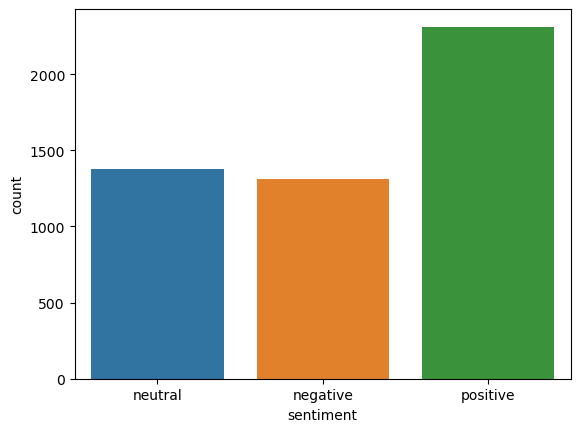

In [18]:
# Lets try to count the distribution of sentiments across the tweets we gathered
sns.countplot(x='sentiment', data=df)

In [19]:
print("Percentage of Tweets each Sentiment occupies: \n" + str(df['sentiment'].value_counts('r')*100))

Percentage of Tweets each Sentiment occupies: 
positive    46.24
neutral     27.52
negative    26.24
Name: sentiment, dtype: float64


In [20]:
data_pos = df[df['sentiment']=='positive'] 
data_neg = df[df['sentiment']=='negative']

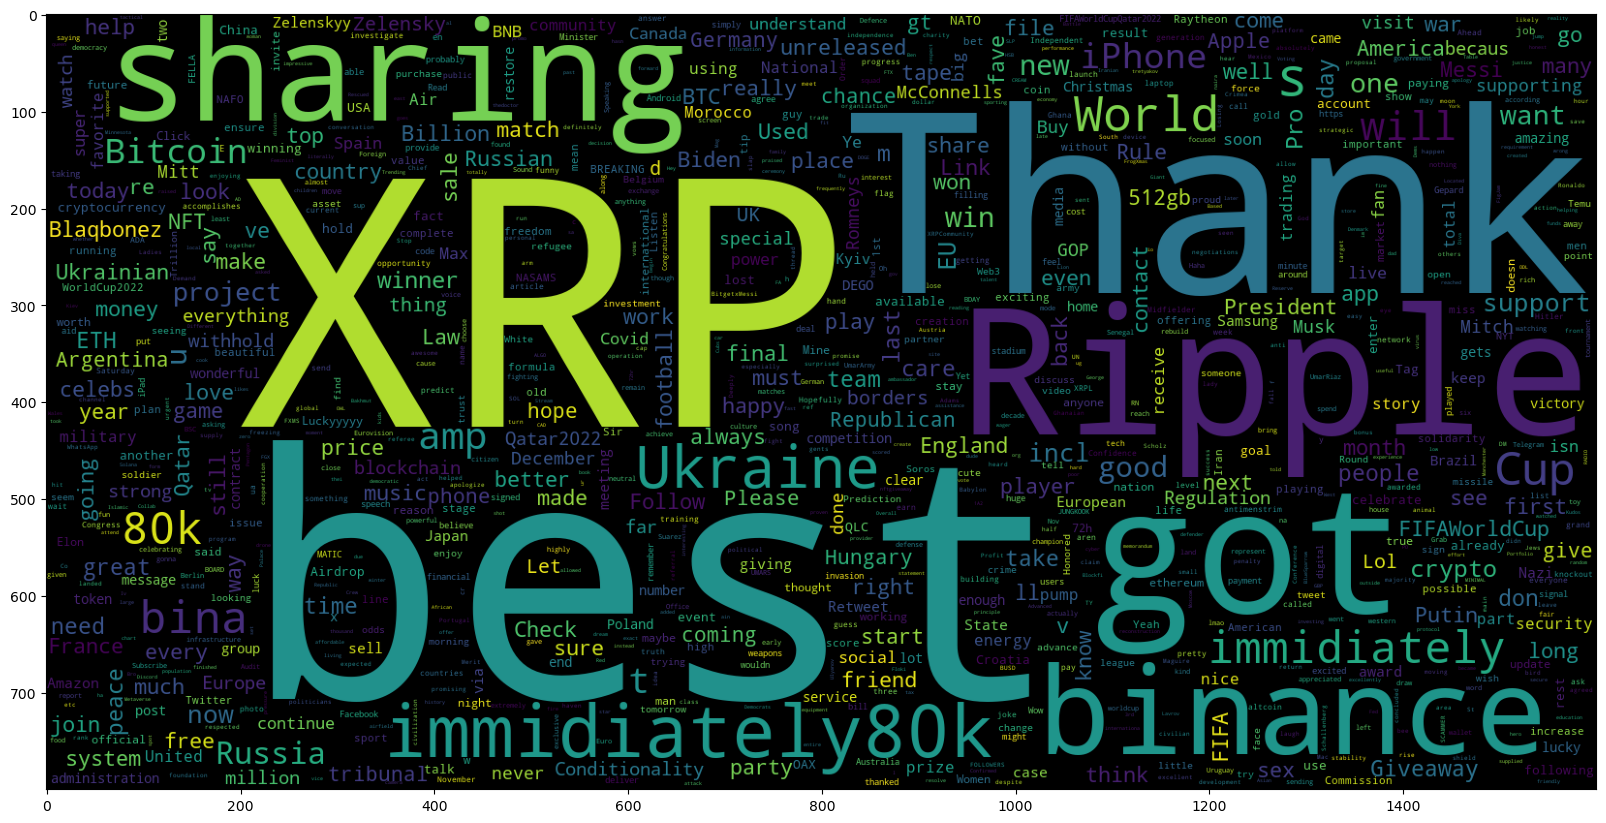

In [21]:
data_pos = data_pos['cleaned_text']

plt.figure(figsize = (20,20))

wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_pos))

plt.imshow(wc)

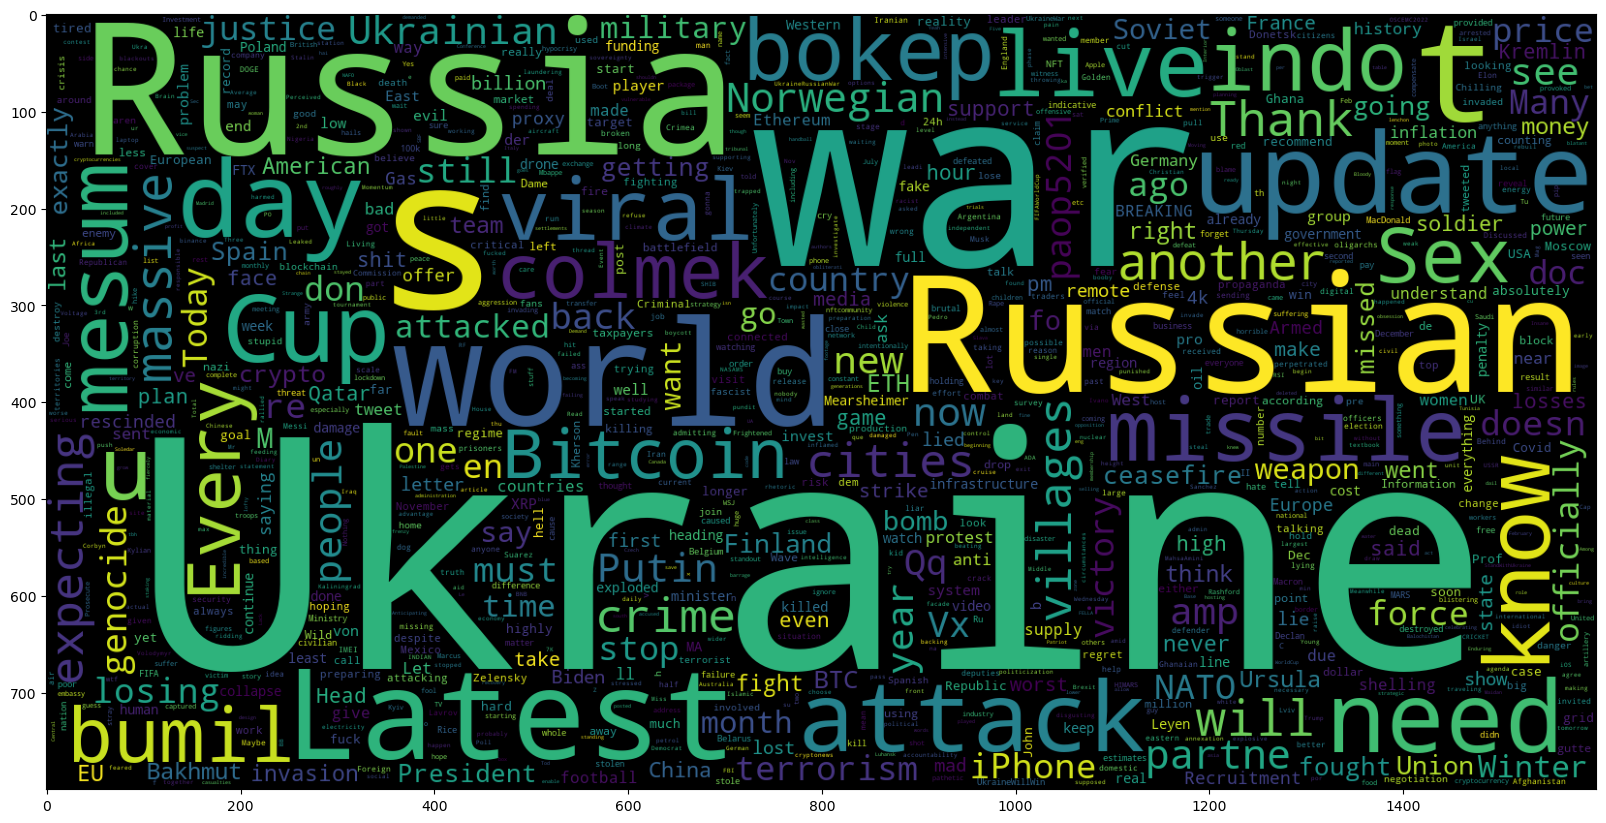

In [22]:
data_neg = data_neg['cleaned_text']

plt.figure(figsize = (20,20))

wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

In [23]:
# Necessary imports

import pyspark.sql.dataframe
from pyspark.sql.functions import regexp_replace, col, lower
from pyspark.sql.types import *
from pyspark.ml.feature import *

# Convert Pandas dataframe to Spark dataframe

schema = StructType([\
    StructField("id", LongType(), True),\
    StructField("text", StringType(), True),\
    StructField("sentiment", StringType(), True)])

df_spark = spark.createDataFrame(df, schema=schema)

In [24]:
df_spark.show()

+-------------------+--------------------+---------+
|                 id|                text|sentiment|
+-------------------+--------------------+---------+
|1598284697469177859|Sell ham for me f...|  neutral|
|1598284696303337472|Zelensky is doing...|  neutral|
|1598284698790367235|this will not be ...| negative|
|1598284695976153089|Ukrainian men amp...| negative|
|1598284698454609920|A referendum on t...|  neutral|
|1598284695925850113|Unfortunately sti...| negative|
|1598284694411673602|They re growing o...| positive|
|1598284700992217090|Every team had to...| positive|
|1598284698463375363|Zelensky is a gre...| positive|
|1598284702687059970|CF Charles When p...|  neutral|
|1598284699545513984|QLC BIG NEWS COMI...|  neutral|
|1598284697725014017|KasiPeople Steenh...| negative|
|1598284699142602753|Olly we know why ...| positive|
|1598284702821257216|Because Putin and...| positive|
|1598284702724816897|                Nope|  neutral|
|1598284702561218563|SHOPEE 11 11 BigS...|  ne

In [25]:
df_spark = df_spark.withColumn('sentiment', regexp_replace('sentiment', 'positive', '1')) # positive -> 1
df_spark = df_spark.withColumn('sentiment', regexp_replace('sentiment', 'negative', '0')) # negative -> 0
df_spark = df_spark.withColumn('sentiment', regexp_replace('sentiment', 'neutral', '2'))  # neutral -> 2

df_spark = df_spark.withColumn("sentiment",col("sentiment").cast("integer")) # convert column from string to int

df_spark.printSchema()

root
 |-- id: long (nullable = true)
 |-- text: string (nullable = true)
 |-- sentiment: integer (nullable = true)



In [26]:
# Lower all the text in the text column and put it in a new column

df_spark = df_spark.select("*", lower(col('text'))) 


In [27]:
df_spark.show()

+-------------------+--------------------+---------+--------------------+
|                 id|                text|sentiment|         lower(text)|
+-------------------+--------------------+---------+--------------------+
|1598284697469177859|Sell ham for me f...|        2|sell ham for me f...|
|1598284696303337472|Zelensky is doing...|        2|zelensky is doing...|
|1598284698790367235|this will not be ...|        0|this will not be ...|
|1598284695976153089|Ukrainian men amp...|        0|ukrainian men amp...|
|1598284698454609920|A referendum on t...|        2|a referendum on t...|
|1598284695925850113|Unfortunately sti...|        0|unfortunately sti...|
|1598284694411673602|They re growing o...|        1|they re growing o...|
|1598284700992217090|Every team had to...|        1|every team had to...|
|1598284698463375363|Zelensky is a gre...|        1|zelensky is a gre...|
|1598284702687059970|CF Charles When p...|        2|cf charles when p...|
|1598284699545513984|QLC BIG NEWS COMI

In [28]:
df_spark = df_spark.select("lower(text)", "sentiment") #get lower(text) and sentiment column
df_spark = df_spark.withColumnRenamed("lower(text)","text") #rename lower(text) column to text

In [29]:
df_spark.show()

+--------------------+---------+
|                text|sentiment|
+--------------------+---------+
|sell ham for me f...|        2|
|zelensky is doing...|        2|
|this will not be ...|        0|
|ukrainian men amp...|        0|
|a referendum on t...|        2|
|unfortunately sti...|        0|
|they re growing o...|        1|
|every team had to...|        1|
|zelensky is a gre...|        1|
|cf charles when p...|        2|
|qlc big news comi...|        2|
|kasipeople steenh...|        0|
|olly we know why ...|        1|
|because putin and...|        1|
|                nope|        2|
|shopee 11 11 bigs...|        2|
|the ukraine pedo ...|        2|
|anticipating coll...|        0|
|zelensky invites ...|        1|
|no i m really not...|        0|
+--------------------+---------+
only showing top 20 rows



In [30]:
# Split training and Testing.
split_data=df_spark.randomSplit([0.7,0.3])
train=split_data[0]

# label in test is renamed to true label.
test=split_data[1].withColumnRenamed("sentiment","true_sentiment")
train_rows=train.count()
test_rows=test.count()

print("Total train :",train_rows)
print("Total test :", test_rows)

Total train : 3477
Total test : 1523


In [31]:
# Tokening the text column would separate each word in a tweet and make one tweet a list of words.

tokenizer = Tokenizer(inputCol="text", outputCol="words")
tokenized_train = tokenizer.transform(df_spark)
tokenized_train.show(truncate=True, n=5)

+--------------------+---------+--------------------+
|                text|sentiment|               words|
+--------------------+---------+--------------------+
|sell ham for me f...|        2|[sell, ham, for, ...|
|zelensky is doing...|        2|[zelensky, is, do...|
|this will not be ...|        0|[this, will, not,...|
|ukrainian men amp...|        0|[ukrainian, men, ...|
|a referendum on t...|        2|[a, referendum, o...|
+--------------------+---------+--------------------+
only showing top 5 rows



In [32]:
# Stop Words Remover will remove all less meaning words like helping verbs, etc.

swr = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol="MeaningfulWords")
SwRemoved_train = swr.transform(tokenized_train)
SwRemoved_train.show(truncate=True, n=5)

+--------------------+---------+--------------------+--------------------+
|                text|sentiment|               words|     MeaningfulWords|
+--------------------+---------+--------------------+--------------------+
|sell ham for me f...|        2|[sell, ham, for, ...|[sell, ham, 40k, ...|
|zelensky is doing...|        2|[zelensky, is, do...|[zelensky, planni...|
|this will not be ...|        0|[this, will, not,...|[fortress, gravey...|
|ukrainian men amp...|        0|[ukrainian, men, ...|[ukrainian, men, ...|
|a referendum on t...|        2|[a, referendum, o...|[referendum, act,...|
+--------------------+---------+--------------------+--------------------+
only showing top 5 rows



In [33]:
# Hashing TF will convert the meaningful words into numerical features.

hashTF = HashingTF(inputCol=swr.getOutputCol(), outputCol="features")
numeric_train = hashTF.transform(SwRemoved_train).select('sentiment', 'MeaningfulWords', 'features')
numeric_train.show(truncate=True, n=3)

+---------+--------------------+--------------------+
|sentiment|     MeaningfulWords|            features|
+---------+--------------------+--------------------+
|        2|[sell, ham, 40k, ...|(262144,[32483,51...|
|        2|[zelensky, planni...|(262144,[30106,16...|
|        0|[fortress, gravey...|(262144,[129535,1...|
+---------+--------------------+--------------------+
only showing top 3 rows



In [34]:
# Import some classifiers and multiclass evaluator as we have three classes -> positive, negative, and neutral.

from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [35]:
# Decision Tree

dt = DecisionTreeClassifier(labelCol="sentiment", featuresCol="features")
model_dt = dt.fit(numeric_train)

In [36]:
# Random Forest

rf = RandomForestClassifier(labelCol="sentiment", featuresCol="features", numTrees=10)
model_rf = rf.fit(numeric_train)

In [37]:
# Naive Bayes

nb = NaiveBayes(smoothing=1.0, modelType="multinomial", labelCol="sentiment", featuresCol="features")
model_nb = nb.fit(numeric_train)

In [38]:
# Prepare Testing data by putting it through the tokenizer, the stop words remover, and the hashing step we did earlier.

tokenized_test = tokenizer.transform(test)
SwRemoved_test = swr.transform(tokenized_test)
numeric_test = hashTF.transform(SwRemoved_test)
numeric_test.show(truncate=True, n=2)

+--------------------+--------------+--------------------+--------------------+--------------------+
|                text|true_sentiment|               words|     MeaningfulWords|            features|
+--------------------+--------------+--------------------+--------------------+--------------------+
|1 m s lorenaraujo...|             1|[1, m, s, lorenar...|[1, m, lorenarauj...|(262144,[10326,18...|
|    100k i m serious|             0|[100k, i, m, seri...|  [100k, m, serious]|(262144,[88342,10...|
+--------------------+--------------+--------------------+--------------------+--------------------+
only showing top 2 rows



In [39]:
# Predictions on the testing set.
pred_dt = model_dt.transform(numeric_test)
pred_rf = model_rf.transform(numeric_test)
pred_nb = model_nb.transform(numeric_test)

In [40]:
# Accuracy Metric
evaluator_A = MulticlassClassificationEvaluator(labelCol="true_sentiment", predictionCol="prediction", metricName="accuracy")

# F1 Metric
evaluator_F = MulticlassClassificationEvaluator(labelCol="true_sentiment", predictionCol="prediction", metricName="f1")

# Weighted Precision
evaluator_P = MulticlassClassificationEvaluator(labelCol="true_sentiment", predictionCol="prediction", metricName="weightedPrecision")

# Weighted Recall
evaluator_R = MulticlassClassificationEvaluator(labelCol="true_sentiment", predictionCol="prediction", metricName="weightedRecall")

# Our models
models = [pred_dt, pred_rf, pred_nb]

# Empty lists that will store the scores for each metric for each model.
accuracy = []
F1 = []
precision = []
recall = []

# Simple loop to populate the empty lists with scores of models for each metric.
for model in models:
    accuracy.append(evaluator_A.evaluate(model))
    F1.append(evaluator_F.evaluate(model))
    precision.append(evaluator_P.evaluate(model))
    recall.append(evaluator_R.evaluate(model))

In [41]:
# We will convert all lists created above into a dataframe for easy viewing.
df_ev = pd.DataFrame(list(zip(accuracy, F1, precision, recall)), 
                     columns = ['Accuracy', 'F1 score', 'Weighted Precision', 'Weighted Recall'],
                     index = ['Decision Tree', 'Random Forest', 'Naive Bayes'])

In [42]:
df_ev

,Accuracy,F1 score,Weighted Precision,Weighted Recall
Decision Tree,0.577150,0.585307,0.825495,0.577150
Random Forest,0.480630,0.323440,0.477194,0.480630
Naive Bayes,0.895601,0.893116,0.903996,0.895601


## Our Approch :

- We used 5000 tweets that extracted from twitter API.
- we cleaned the tweets  by removing links, special characters, and punctuations.
- for getting the sentiments for each tweet ,  we imported the Sentiment Intensity Analyzer from nltk.
- The Percentage of Tweets for each Sentiment :  Positive = 46.24% , Neutral=27.52% , Negative= 26.24%

## Finding : 

After predicting the sentimnet of the text , As we can see from the table above that the best Accuracy, F1 score, Weighted Precision , and Weighted Recall is by implementing the Naive Bayes algorithm with large difference with the other two algorithms. 